<a href="https://colab.research.google.com/github/akats16/CoronaVirusAnalysis/blob/master/ExploringCovid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Loading in various packages**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.ticker import MaxNLocator
import datetime
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

**2. Loading raw datasets from [Kaggle](https://www.kaggle.com/tags/covid19)**

Additionally, I created a dataset that explores how many confirmed, recovered, and death cases there are across the globe on January 22,2020 to March 26,2020

In [ ]:

confirmedCases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recoveredCases=  pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
deathCases= pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
confirmedSub = confirmedCases[['Province/State', 'Country/Region', 'Lat', 'Long']]
# locationCovid = pd.merge(covidData, confirmedSub, on=['Province/State','Country/Region'])

**3. Creating dataset that looks at death-rate vs recovery-rate globally**

In [ ]:
firstDayConfirmed = confirmedCases.columns.str.startswith('1', na=False)
firstIndexConfirmed = int(next((i for i, j in enumerate(firstDayConfirmed) if j), None))

totalConfirmedPerDay = confirmedCases.iloc[:,firstIndexConfirmed:len(confirmedCases)].agg([sum])
total1 = totalConfirmedPerDay.append(recoveredCases.iloc[:,firstIndexConfirmed:len(confirmedCases)].agg([sum]))
totalCases = total1.append(deathCases.iloc[:,firstIndexConfirmed:len(confirmedCases)].agg([sum]))

totalCases = totalCases.transpose()
totalCases.columns = ['Confirmed', 'Recovered', 'Deaths']

totalCases['RecoveredRate'] = totalCases['Recovered']/totalCases['Confirmed']
totalCases['DeathRate'] = totalCases['Deaths']/totalCases['Confirmed']


totalCases.head()

,Confirmed,Recovered,Deaths,RecoveredRate,DeathRate
1/22/20,555,28,17,0.050450,0.030631
1/23/20,654,30,18,0.045872,0.027523
1/24/20,941,36,26,0.038257,0.027630
1/25/20,1434,39,42,0.027197,0.029289
1/26/20,2118,52,56,0.024551,0.026440


In [ ]:
covidData.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
locationCovid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Lat,Long
0,36,01/22/2020,NaN,Japan,1/22/2020 17:00,2.0,0.0,0.0,36.0,138.0
1,74,01/23/2020,NaN,Japan,1/23/20 17:00,1.0,0.0,0.0,36.0,138.0
2,120,01/24/2020,NaN,Japan,1/24/20 17:00,2.0,0.0,0.0,36.0,138.0
3,161,01/25/2020,NaN,Japan,1/25/20 17:00,2.0,0.0,0.0,36.0,138.0
4,207,01/26/2020,NaN,Japan,1/26/20 16:00,4.0,0.0,1.0,36.0,138.0


In [ ]:
covidByDay = covidData.groupby(['ObservationDate'])[["Confirmed", "Deaths", "Recovered"]].sum()
covidByDay.head()

,Confirmed,Deaths,Recovered
ObservationDate,,,
01/22/2020,555.0,17.0,28.0
01/23/2020,653.0,18.0,30.0
01/24/2020,941.0,26.0,36.0
01/25/2020,1438.0,42.0,39.0
01/26/2020,2118.0,56.0,52.0


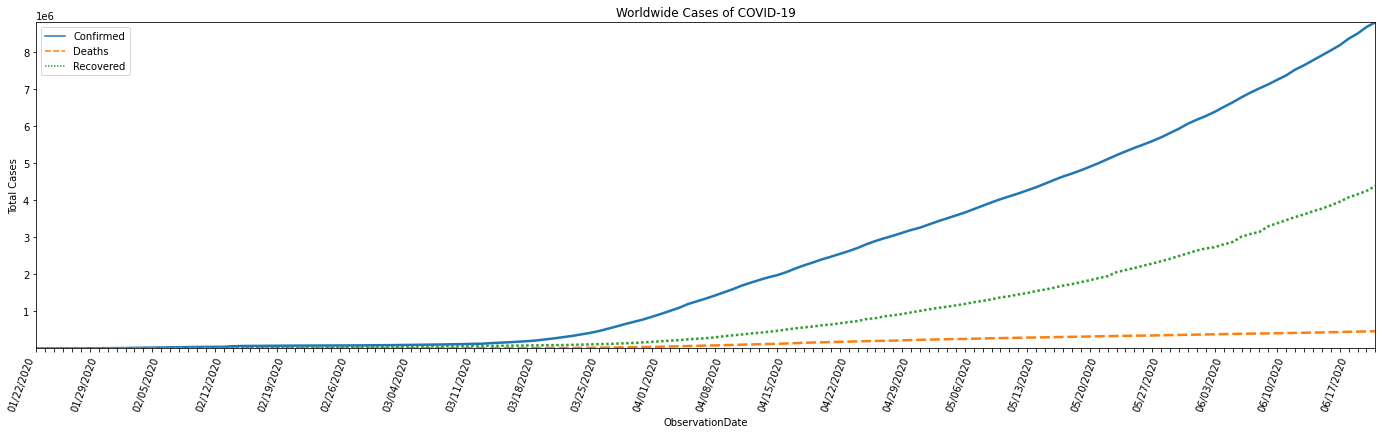

In [ ]:
labels = covidByDay.index.get_level_values(0).values

plt.figure(figsize=(24, 6))
ax = sns.lineplot(data=covidByDay, palette="tab10", linewidth=2.5)
ax.set_xticklabels(labels, rotation=70, horizontalalignment='right')
ax.set_ylabel('Total Cases')
ax.set_title('Worldwide Cases of COVID-19')
ax.margins(0)

n = 7  # Keeps every 7th label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

ax

In [ ]:
worldwide = px.density_mapbox(locationCovid, lat='Lat', lon='Long', hover_name='Country/Region', 
                  animation_frame='ObservationDate', zoom=0, radius=10, 
                  hover_data=['Confirmed','Recovered', 'Deaths'], mapbox_style="stamen-terrain", title='Worldwide Cases')

worldwide.show()

**Below is a graph of the global death and recovery rates. **
Note: will be adding an analysis of individual countries with highest death rates to compare to global data

Text(0.5, 1.0, 'Death Rate/ Day Globally')

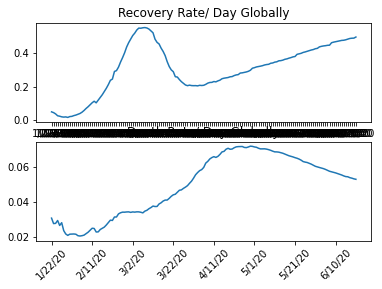

In [ ]:
plt.figure(1)
plt.subplot(211)
plt.plot(totalCases.index, totalCases['RecoveredRate'])
ax = plt.gca()
ax.set_title('Recovery Rate/ Day Globally')
plt.subplot(212)
plt.plot(totalCases.index, totalCases['DeathRate'])
plt.xticks(rotation=45)
locator = MaxNLocator(nbins=10)

ax2 = plt.gca()
ax2.xaxis.set_major_locator(locator)
ax2.set_title('Death Rate/ Day Globally')

**Support Vector Regression Model**: predict number of worldwide confirmed cases

In [ ]:
days = confirmedCases.iloc[:, 4:-1].keys()
days_in_future = 15
future_forcast = np.array([i for i in range(len(days)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

adjusted_dates

In [ ]:
world_cases = []
for i in days:
    confirmed_sum = confirmedCases[i].sum()
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)


world_cases

In [ ]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

days_since_1_22 = np.array([i for i in range(len(days))]).reshape(-1, 1)

In [ ]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[50:], world_cases[50:], test_size=0.2, shuffle=False)

In [ ]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 269349.07843080495
MSE: 89951826205.2448


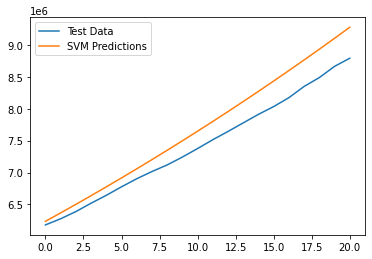

In [ ]:
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

MAE: 48479.8645025293
MSE: 3389624902.5527663


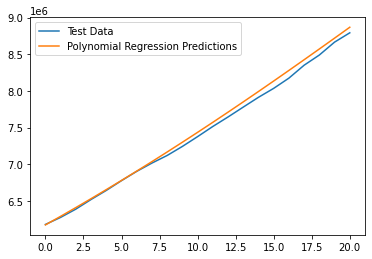

In [ ]:
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))


plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])